## Sparse Stardist training example

Once we have sparse labels the training process is the same as non-sparse. 

In [1]:
import os
from tnia.plotting.plt_helper import imshow_multi2d
import tensorflow as tf
from pathlib import Path
import json

2024-10-23 06:02:12.641668: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-23 06:02:12.651885: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-23 06:02:12.666401: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-23 06:02:12.666425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-23 06:02:12.675863: I tensorflow/core/platform/cpu_feature_gua

## Check what devices we have access to....

Not as important to have a beefy GPU for 2D as it is for 3D, but let's check

In [2]:
visible_devices = tf.config.list_physical_devices()
print(visible_devices)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-10-23 06:02:15.285568: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 06:02:15.327907: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 06:02:15.328063: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Load inputs and ground truth

We load directories called 'input0' and 'ground truth0' which should exist under ```train_path```.  The reason we append '0' to the end of the name is simply because some of the code that generates image and label sets is meant to work on multiple channels (so the 0 is the channel number)

In [3]:

#tnia_images_path = Path(r'/home/bnorthan/images')
tnia_images_path = Path("D:/images")
data_path = r'C:\Users\bnort\work\ImageJ2022\tnia\notebooks-and-napari-widgets-for-dl\data'
data_path = r'/home/bnorthan/code/i2k/tnia/notebooks-and-napari-widgets-for-dl/data'
parent_path = os.path.join(data_path, 'ladybugs_sparse')
#test_name='bsp1-2.jpg'
n_rays = 32

train_path = os.path.join(parent_path , 'patches')

with open(os.path.join(train_path , 'info.json'), 'r') as json_file:
    data = json.load(json_file)
    # Access the sub_sample parameter
    sub_sample = data['sub_sample']
    print('sub_sample',sub_sample)
    axes = data['axes']
    print('axes',axes)

image_patch_path = os.path.join(train_path , 'ground truth0')
label_patch_path = os.path.join(train_path , 'input0' )

model_path = os.path.join(parent_path , 'models')

if not os.path.exists(model_path):
    os.makedirs(model_path)

if not os.path.exists(image_patch_path):
    print('image_patch_path does not exist')

if not os.path.exists(label_patch_path):
    print('label_patch_path does not exist')

sub_sample 1
axes YXC


## Use a helper to collect the training data

The helper will also optionally normalize the inputs.

Normalization is a tricky issue sometimes it makes sense to normalize before creating patches, such that the data is normalized based on statistics of a larger region, closer to the normalization range that will be used for prediction. 

In [4]:
from tnia.deeplearning.dl_helper import collect_training_data
add_trivial_channel = False

X, Y = collect_training_data(train_path, sub_sample=1, downsample=False, normalize_input=False, add_trivial_channel = add_trivial_channel)

print('type X ', type(X))
print('type Y ', type(Y))

raster_geometry not imported.  This is only needed for the ellipsoid rendering in apply_stardist
type X  <class 'list'>
type Y  <class 'list'>


## Inspect images

Output training data shapes and plot images to make sure image and label set look OK 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007905139..1.0].


(256, 256, 3) (256, 256)
-0.007905139 1.0
0 65535


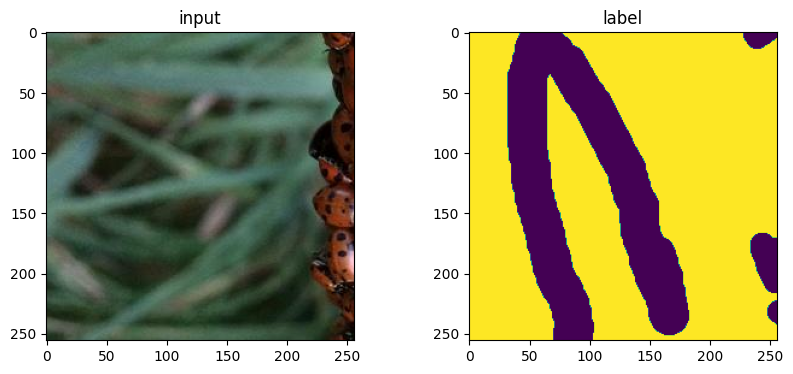

In [5]:
n=35
print(X[n].shape, Y[n].shape)
print(X[n].min(), X[n].max())
print(Y[n].min(), Y[n].max())
fig=imshow_multi2d([X[n], Y[n]], ['input', 'label'], 1,2)

## Check to make sure we have negative values in the labels

In [9]:
from tnia.deeplearning.dl_helper import divide_training_data

X_train, Y_train, X_val, Y_val = divide_training_data(X, Y, val_size=2)

Y_train = Y_train.astype('int16')
Y_val = Y_val.astype('int16')

print(Y_train.min(), Y_train.max())

-1 44


## Create stardist model

In this cell we create the model.  Make sure to rename the model and give it a descriptive name that conveys the training data and setting used. 

In [10]:
from stardist.models import StarDist2D, Config2D
from tnia.deeplearning.dl_helper import augmenter

if axes == 'YXC':
    n_channel_in =3
else:
    n_channel_in = 1

model_name = "ladybug_sparse"
new_model = True 

if new_model:

    config = Config2D (n_rays=n_rays, axes=axes,n_channel_in=n_channel_in, train_patch_size = (256,256), unet_n_depth=3)
    model = StarDist2D(config=config, name=model_name, basedir=model_path)
else:
    model = StarDist2D(config=None, name=model_name, basedir=model_path)

base_model.py (198): output path for model already exists, files may be overwritten: /home/bnorthan/code/i2k/tnia/notebooks-and-napari-widgets-for-dl/data/ladybugs_sparse/models/ladybug_sparse
2024-10-23 06:06:23.260110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 06:06:23.260265: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-23 06:06:23.260343: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had 

Using default values: prob_thresh=0.5, nms_thresh=0.4.


## Train the model

In [11]:
#model.train(X_train, Y_train, validation_data=(X_val,Y_val),epochs=100, steps_per_epoch=200, augmenter=augmenter) 
model.train(X_train, Y_train, validation_data=(X_val,Y_val),epochs=200, steps_per_epoch=200) 

Epoch 1/200


I0000 00:00:1729678015.834298  126696 service.cc:145] XLA service 0x7de3a0002790 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729678015.834325  126696 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2024-10-23 06:06:55.919704: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-10-23 06:07:01.314635: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  3/200 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - dist_dist_iou_metric: 7.4945e-06 - dist_relevant_mae: 16.6135 - dist_relevant_mse: 367.0920 - loss: 4.0206 - prob_kld: 0.3650  

I0000 00:00:1729678031.069700  126696 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


200/200 ━━━━━━━━━━━━━━━━━━━━ 35s 85ms/step - dist_dist_iou_metric: 0.1627 - dist_relevant_mae: 11.3809 - dist_relevant_mse: 211.2150 - loss: 2.9400 - prob_kld: 0.3043 - val_dist_dist_iou_metric: 0.2841 - val_dist_relevant_mae: 9.9700 - val_dist_relevant_mse: 191.5270 - val_loss: 2.8396 - val_prob_kld: 0.3304 - learning_rate: 3.0000e-04
Epoch 2/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - dist_dist_iou_metric: 0.3767 - dist_relevant_mae: 7.1337 - dist_relevant_mse: 91.8835 - loss: 2.0531 - prob_kld: 0.2562 - val_dist_dist_iou_metric: 0.2686 - val_dist_relevant_mae: 10.0539 - val_dist_relevant_mse: 198.0379 - val_loss: 2.6728 - val_prob_kld: 0.1469 - learning_rate: 3.0000e-04
Epoch 3/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - dist_dist_iou_metric: 0.3968 - dist_relevant_mae: 6.8994 - dist_relevant_mse: 87.3241 - loss: 1.9318 - prob_kld: 0.1855 - val_dist_dist_iou_metric: 0.4432 - val_dist_relevant_mae: 7.3069 - val_dist_relevant_mse: 108.2121 - val_loss: 2.1132 - val_prob_kld: 0.

In [14]:
# Not sure optimize threshold works with sparse labeling
#model.optimize_thresholds(X_train, Y_train)

## Test network on one of the training images (self prediction)

Self prediction is not a good way to evaluate the 'real' performance of the NN.  However it is good sanity test.  If the self prediction looks wrong something really went bad. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007905139..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024096385..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007905139..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.007905139..1.0].


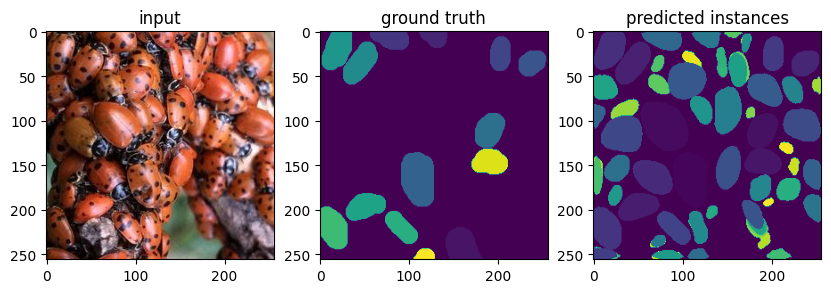

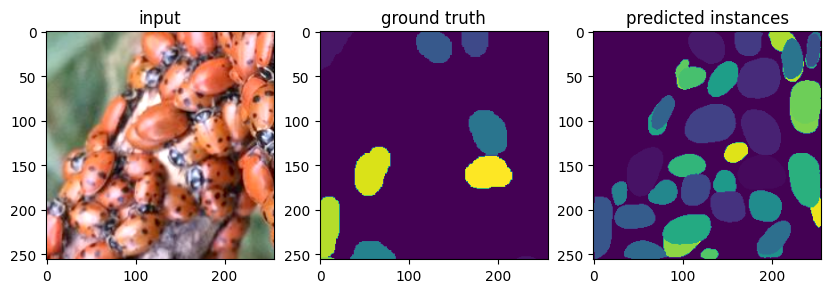

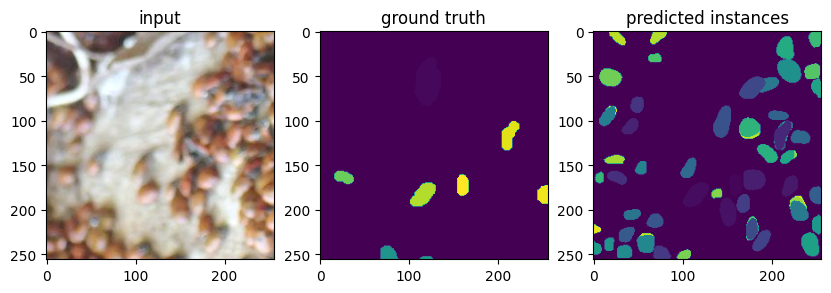

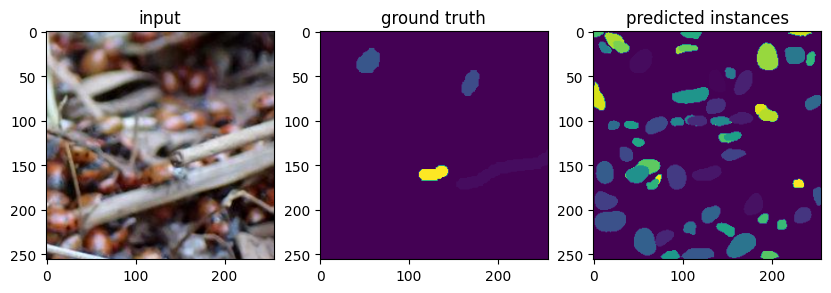

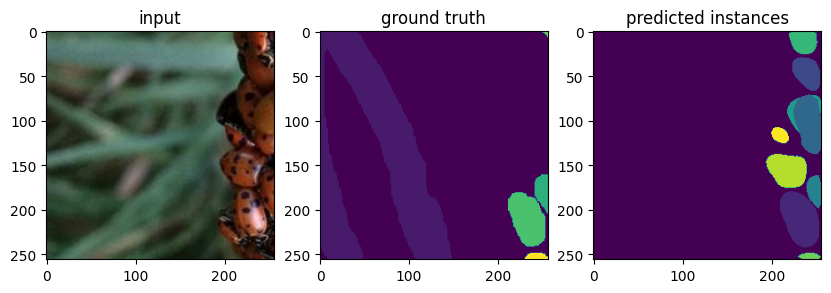

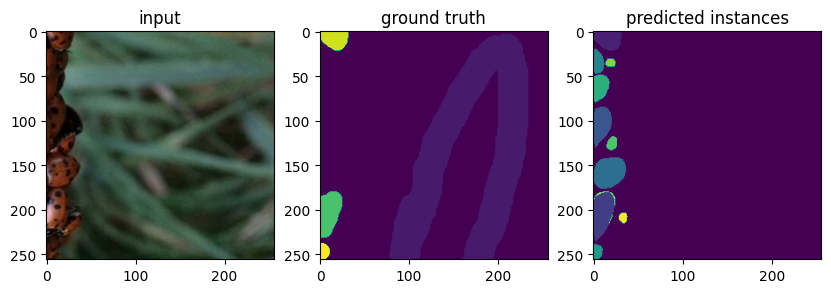

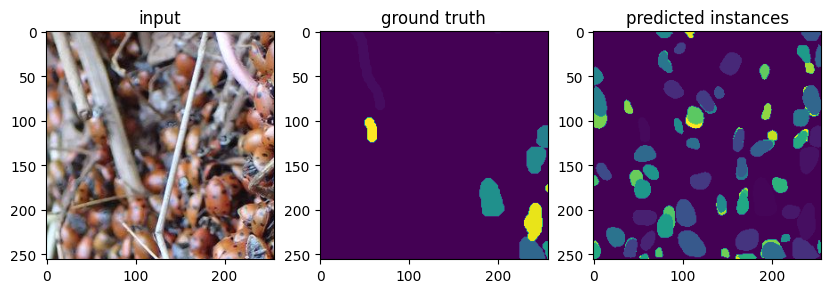

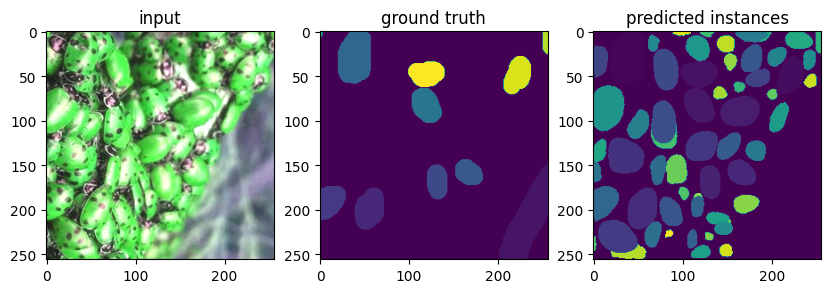

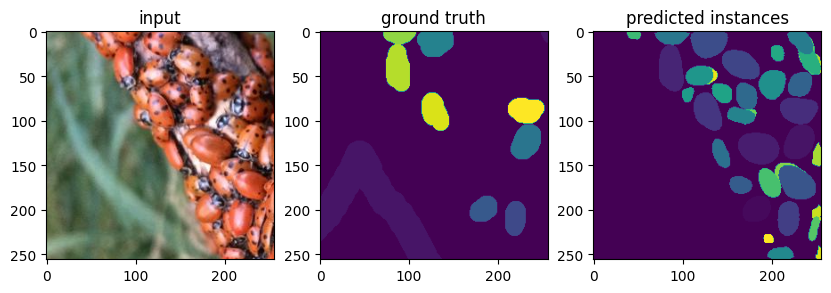

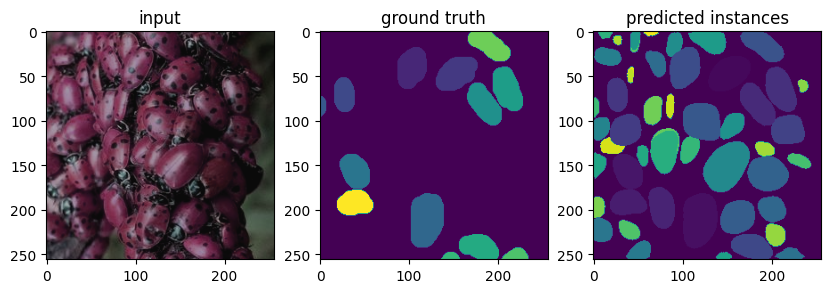

In [15]:
for n in range(10):
    labels, details = model.predict_instances(X_train[n], prob_thresh=0.5, nms_thresh=0.9)
    fig = imshow_multi2d([X_train[n],Y_train[n],labels],['input','ground truth','predicted instances'],1,3)
